#  <center> Speech Emotion Detection <center>

# Download Dataset

In [ ]:
!gdown "1ur4CrYKZT197pOCdZCSt-7DabXbcp-x_"

Downloading...
From: https://drive.google.com/uc?id=1ur4CrYKZT197pOCdZCSt-7DabXbcp-x_
To: /content/kaggle.json
100% 63.0/63.0 [00:00<00:00, 283kB/s]


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

 99% 424M/429M [00:05<00:00, 83.9MB/s]
100% 429M/429M [00:05<00:00, 85.2MB/s]


In [ ]:
!unzip ravdess-emotional-speech-audio.zip -d /content/dataset

Archive:  ravdess-emotional-speech-audio.zip
  inflating: /content/dataset/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: /content/dataset/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: /content/dataset/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: /content/dataset/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-02-01-01-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-02-01-02-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-02-02-01-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-02-02-02-01.wav  
  inflating: /content/dataset/Actor_01/03-01-03-01-01-01-01.wav  
  inflating: /content/dataset/Actor_01/03-01-03-01-01-02-01.wav  
  inflating: /content/dataset/A

In [ ]:
#!rm -rf /content/*

In [ ]:
import pandas as pd
import numpy as np
import re
import os
import sys
import shutil

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.utils import to_categorical

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Data Preparation


In [ ]:
base_source_directory = '/content/dataset/'
destination_directories = {
    'Depression': '/content/dataset/ravdes/Depression/',
    'NonDepression': '/content/dataset/ravdes/NonDepression/'
}

def copy_files_with_specific_number():
    count = 0
    for i in range(1, 25):
        actor_folder = f"Actor_{str(i).zfill(2)}"
        source_directory = os.path.join(base_source_directory, actor_folder)

        for category, base_destination_directory in destination_directories.items():
            destination_directory = os.path.join(base_destination_directory, actor_folder)

            if not os.path.exists(destination_directory):
                os.makedirs(destination_directory)

            for filename in os.listdir(source_directory):
                if '-' in filename:
                    parts = filename.split('-')
                    if len(parts) >= 3:
                        number = parts[2][:2]
                        if (category == 'Depression' and number in ['04', '05', '06', '07']) or \
                           (category == 'NonDepression' and number in ['01', '02', '03', '08']):
                            source_path = os.path.join(source_directory, filename)
                            destination_path = os.path.join(destination_directory, filename)
                            shutil.copy(source_path, destination_path)
                            count += 1
    print(f"Total files moved: {count}")

copy_files_with_specific_number()

Total files moved: 1440


In [ ]:
records = []
for dirname, _, filenames in os.walk('/content/dataset/ravdes'):
    for filename in filenames:
        records.append([filename, os.path.join(dirname,filename)])

data = pd.DataFrame(records, columns=['filename','Path'])
data['actor'] = data['Path'].apply(lambda x: re.findall("\w+_\d+",x)[0])
data = data[data['actor']!="audio_speech_actors_01"]
data.reset_index(inplace=True,drop=True)
data['type'] = data['filename'].apply(lambda x: re.split("-\d+\.wav",x)[0])
data

filename  \
0     03-01-05-02-02-01-08.wav   
1     03-01-05-02-01-02-08.wav   
2     03-01-07-01-01-01-08.wav   
3     03-01-04-01-01-01-08.wav   
4     03-01-04-02-02-01-08.wav   
...                        ...   
1435  03-01-01-01-02-01-24.wav   
1436  03-01-03-02-02-01-24.wav   
1437  03-01-08-02-01-01-24.wav   
1438  03-01-03-01-02-02-24.wav   
1439  03-01-03-02-02-02-24.wav   

                                                   Path     actor  \
0     /content/dataset/ravdes/Depression/Actor_08/03...  Actor_08   
1     /content/dataset/ravdes/Depression/Actor_08/03...  Actor_08   
2     /content/dataset/ravdes/Depression/Actor_08/03...  Actor_08   
3     /content/dataset/ravdes/Depression/Actor_08/03...  Actor_08   
4     /content/dataset/ravdes/Depression/Actor_08/03...  Actor_08   
...                                                 ...       ...   
1435  /content/dataset/ravdes/NonDepression/Actor_24...  Actor_24   
1436  /content/dataset/ravdes/NonDepression/Actor_24...  Actor_24   
1437  /content/dataset/ravdes/NonDepression/Actor_24...  Actor_24   
1438  /content/dataset/ravdes/NonDepression/Actor_24...  Actor_24   
1439  /content/dataset/ravdes/NonDepression/Actor_24...  Actor_24   

                   type  
0     03-01-05-02-02-01  
1     03-01-05-02-01-02  
2     03-01-07-01-01-01  
3     03-01-04-01-01-01  
4     03-01-04-02-02-01  
...                 ...  
1435  03-01-01-01-02-01  
1436  03-01-03-02-02-01  
1437  03-01-08-02-01-01  
1438  03-01-03-01-02-02  
1439  03-01-03-02-02-02  

[1440 rows x 4 columns]

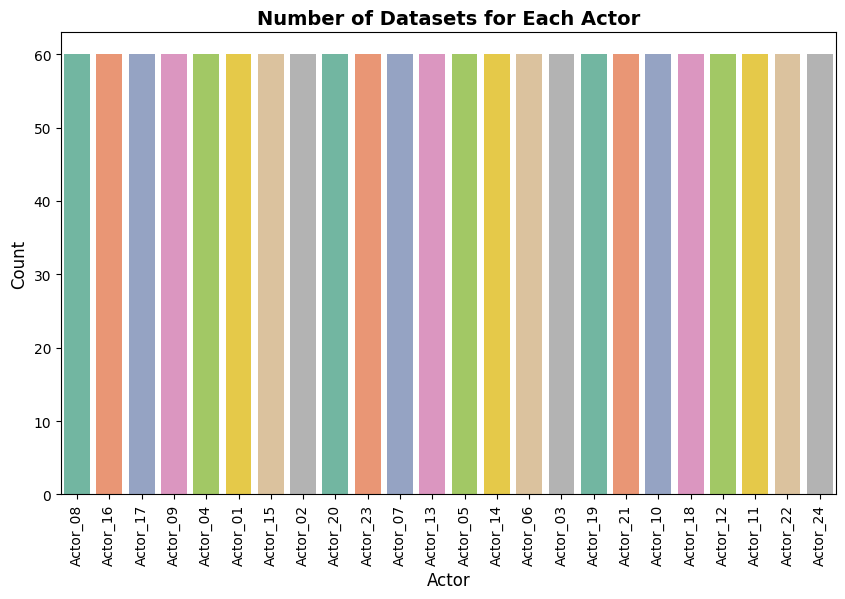

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='actor', data=data, palette="Set2", order = data['actor'].value_counts().index)

plt.title('Number of Datasets for Each Actor', fontsize=14, fontweight='bold')
plt.xlabel('Actor', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=90)

plt.show()

In [ ]:
def classify_emotion(emotion):
    if emotion in ['01', '02', '03', '08']:
        return 'NonDepression'
    elif emotion in ['04', '05', '06', '07']:
        return 'Depression'

def label_gender(actor):
    if int(actor) % 2 == 0:
        return 'female'
    else:
        return 'male'
data['Emotions'] = data['type'].apply(lambda x: classify_emotion(x.split('-')[2]))
data['gender'] = data['type'].apply(lambda x: label_gender(x.split('-')[5]))
data

filename  \
0     03-01-05-02-02-01-08.wav   
1     03-01-05-02-01-02-08.wav   
2     03-01-07-01-01-01-08.wav   
3     03-01-04-01-01-01-08.wav   
4     03-01-04-02-02-01-08.wav   
...                        ...   
1435  03-01-01-01-02-01-24.wav   
1436  03-01-03-02-02-01-24.wav   
1437  03-01-08-02-01-01-24.wav   
1438  03-01-03-01-02-02-24.wav   
1439  03-01-03-02-02-02-24.wav   

                                                   Path     actor  \
0     /content/dataset/ravdes/Depression/Actor_08/03...  Actor_08   
1     /content/dataset/ravdes/Depression/Actor_08/03...  Actor_08   
2     /content/dataset/ravdes/Depression/Actor_08/03...  Actor_08   
3     /content/dataset/ravdes/Depression/Actor_08/03...  Actor_08   
4     /content/dataset/ravdes/Depression/Actor_08/03...  Actor_08   
...                                                 ...       ...   
1435  /content/dataset/ravdes/NonDepression/Actor_24...  Actor_24   
1436  /content/dataset/ravdes/NonDepression/Actor_24...  Actor_24   
1437  /content/dataset/ravdes/NonDepression/Actor_24...  Actor_24   
1438  /content/dataset/ravdes/NonDepression/Actor_24...  Actor_24   
1439  /content/dataset/ravdes/NonDepression/Actor_24...  Actor_24   

                   type       Emotions  gender  
0     03-01-05-02-02-01     Depression    male  
1     03-01-05-02-01-02     Depression  female  
2     03-01-07-01-01-01     Depression    male  
3     03-01-04-01-01-01     Depression    male  
4     03-01-04-02-02-01     Depression    male  
...                 ...            ...     ...  
1435  03-01-01-01-02-01  NonDepression    male  
1436  03-01-03-02-02-01  NonDepression    male  
1437  03-01-08-02-01-01  NonDepression    male  
1438  03-01-03-01-02-02  NonDepression  female  
1439  03-01-03-02-02-02  NonDepression  female  

[1440 rows x 6 columns]

## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

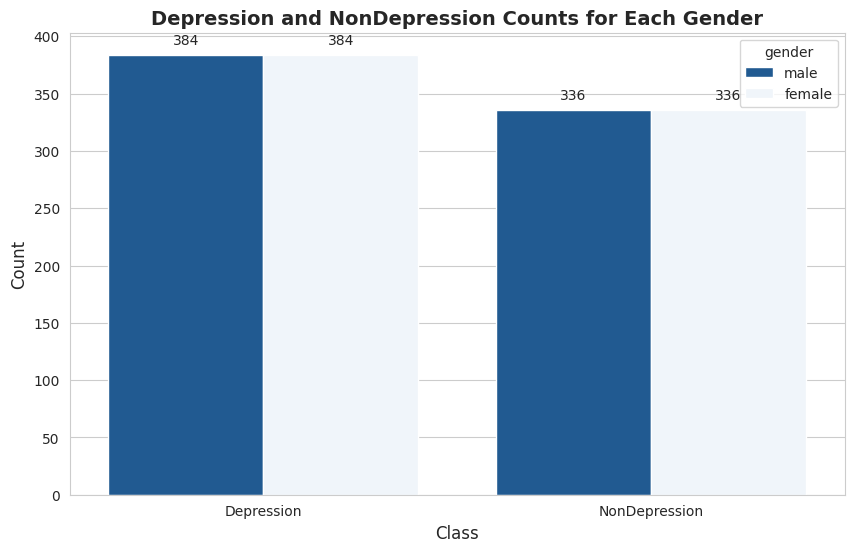

In [ ]:
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
palette = ["#0f5aa3", "#eef5fc"]  # Biru tua dan biru muda
ax = sns.countplot(x='Emotions', hue='gender', data=data, palette=palette)

plt.title('Depression and NonDepression Counts for Each Gender', fontsize=14, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.show()

In [ ]:
def process_directory(directory, emotion_replacement):
    directory_list = os.listdir(directory)

    file_emotion = []
    file_path = []
    for dir in directory_list:
        actor = os.listdir(directory + '/' + dir)
        for file in actor:
            part = file.split('.')[0]
            part = part.split('-')
            file_emotion.append(int(part[2]))
            file_path.append(directory + dir + '/' + file)

    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
    path_df = pd.DataFrame(file_path, columns=['Path'])
    df = pd.concat([emotion_df, path_df], axis=1)

    df.Emotions.replace(emotion_replacement, inplace=True)
    return df

Ravdessdepre = "/content/dataset/ravdes/Depression"
Ravdessnon = "/content/dataset/ravdes/NonDepression"

Ravdessdepre_df = process_directory(Ravdessdepre, {4:'depressed', 5:'depressed', 6:'depressed', 7:'depressed'})
Ravdessnon_df = process_directory(Ravdessnon, {1:'non depressed', 2:'non depressed', 3:'non depressed', 8:'non depressed'})

# Menambahkan kolom 'Category' ke kedua DataFrame
Ravdessdepre_df['Category'] = 'Depressed'
Ravdessnon_df['Category'] = 'Non-Depressed'

# Menggabungkan kedua DataFrame
data_path = pd.concat([Ravdessdepre_df, Ravdessnon_df], keys=['Depressed', 'Non-Depressed'], axis=0)
data_path

Emotions  \
Depressed     0        depressed   
              1        depressed   
              2        depressed   
              3        depressed   
              4        depressed   
...                          ...   
Non-Depressed 667  non depressed   
              668  non depressed   
              669  non depressed   
              670  non depressed   
              671  non depressed   

                                                                Path  \
Depressed     0    /content/dataset/ravdes/DepressionActor_08/03-...   
              1    /content/dataset/ravdes/DepressionActor_08/03-...   
              2    /content/dataset/ravdes/DepressionActor_08/03-...   
              3    /content/dataset/ravdes/DepressionActor_08/03-...   
              4    /content/dataset/ravdes/DepressionActor_08/03-...   
...                                                              ...   
Non-Depressed 667  /content/dataset/ravdes/NonDepressionActor_24/...   
              668  /content/dataset/ravdes/NonDepressionActor_24/...   
              669  /content/dataset/ravdes/NonDepressionActor_24/...   
              670  /content/dataset/ravdes/NonDepressionActor_24/...   
              671  /content/dataset/ravdes/NonDepressionActor_24/...   

                        Category  
Depressed     0        Depressed  
              1        Depressed  
              2        Depressed  
              3        Depressed  
              4        Depressed  
...                          ...  
Non-Depressed 667  Non-Depressed  
              668  Non-Depressed  
              669  Non-Depressed  
              670  Non-Depressed  
              671  Non-Depressed  

[1440 rows x 3 columns]

We can also plot waveplots and spectograms for audio signals

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio {}'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio {}'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

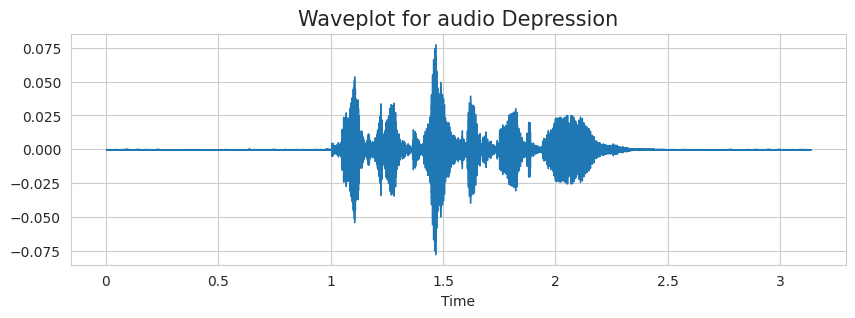

In [ ]:
emotion = 'Depression'
path = "/content/dataset/ravdes/Depression/Actor_05/03-01-06-01-01-01-05.wav"
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
emotion='angry'
path = '/content/dataset/ravdes/Depression/Actor_05/03-01-05-01-02-01-05.wav'
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

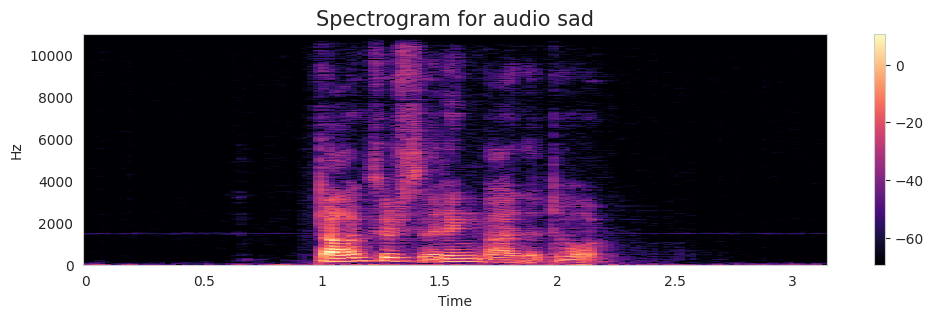

In [ ]:
emotion='sad'
path = '/content/dataset/ravdes/Depression/Actor_05/03-01-04-02-02-02-05.wav'
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

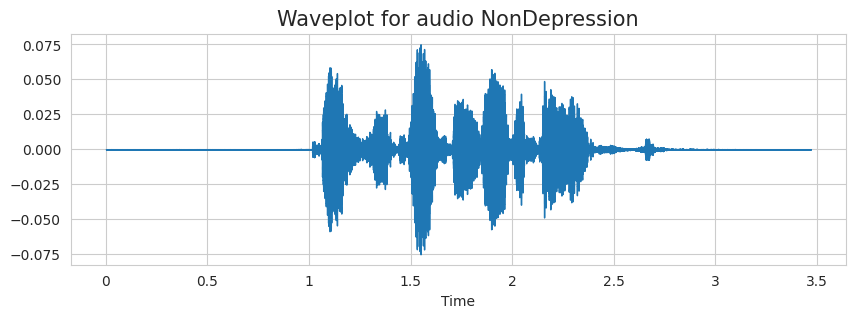

In [ ]:
emotion='NonDepression'
path = '/content/dataset/ravdes/NonDepression/Actor_01/03-01-03-01-01-02-01.wav'
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.
- In images data augmention can be performed by shifting the image, zooming, rotating ...

First, let's check which augmentation techniques works better for our dataset.

In [ ]:
depression_data = []
non_depression_data = []
directories = [
    '/content/dataset/ravdes/Depression',
    '/content/dataset/ravdes/NonDepression'
]

def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, n_steps=0):
    return librosa.effects.pitch_shift(data, sr=sample_rate, n_steps=n_steps)

for directory in directories:
    for root, dirs, files in os.walk(directory):
        for filename in files:
            if filename.endswith('.wav'):
                filepath = os.path.join(root, filename)
                if 'depression' in filepath.lower():
                    depression_data.append(filepath)
                elif 'non depression' in filepath.lower():
                    non_depression_data.append(filepath)

#### 1. Simple Audio

In [ ]:
pathnew = '/content/dataset/ravdes/NonDepression/Actor_05/03-01-01-01-02-01-05.wav'

plt.figure(figsize=(14, 4))
plt.plot(data)
plt.title('Waveplot', size=16)
plt.xlabel('Time', size=12)
plt.ylabel('Amplitude', size=12)
plt.show()

Audio(pathnew)

#### 2. Noise Injection

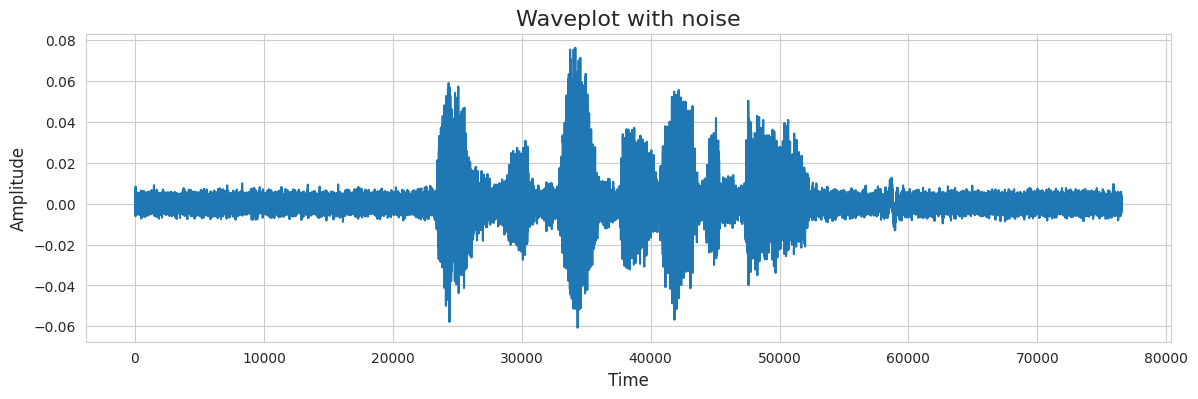

In [ ]:
x = noise(data)
plt.figure(figsize=(14, 4))
plt.plot(x)
plt.title('Waveplot with noise', size=16)
plt.xlabel('Time', size=12)
plt.ylabel('Amplitude', size=12)
plt.show()
data,sample_rate = librosa.load(pathnew)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3. Stretching

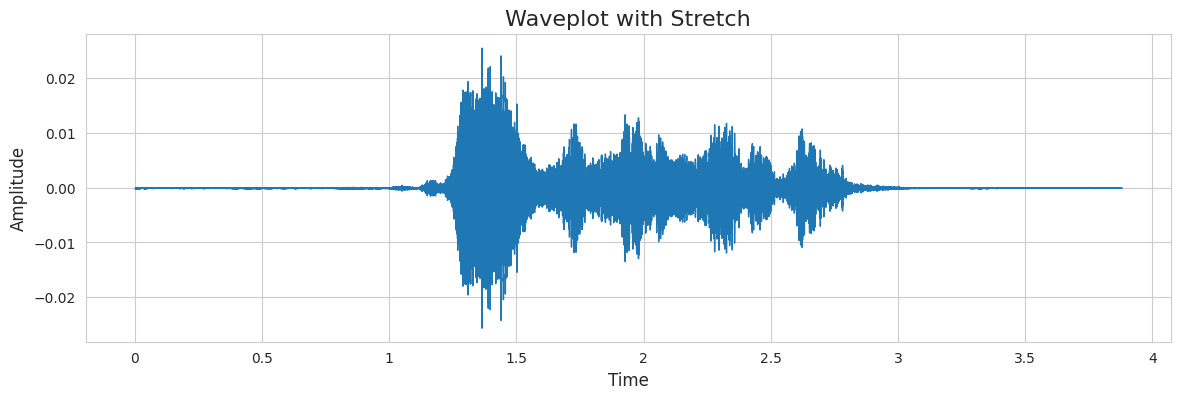

In [ ]:
x = stretch(data, rate=0.8)

plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Waveplot with Stretch', size=16)
plt.xlabel('Time', size=12)
plt.ylabel('Amplitude', size=12)
plt.show()

Audio(x, rate=sample_rate)

#### 4. Shifting

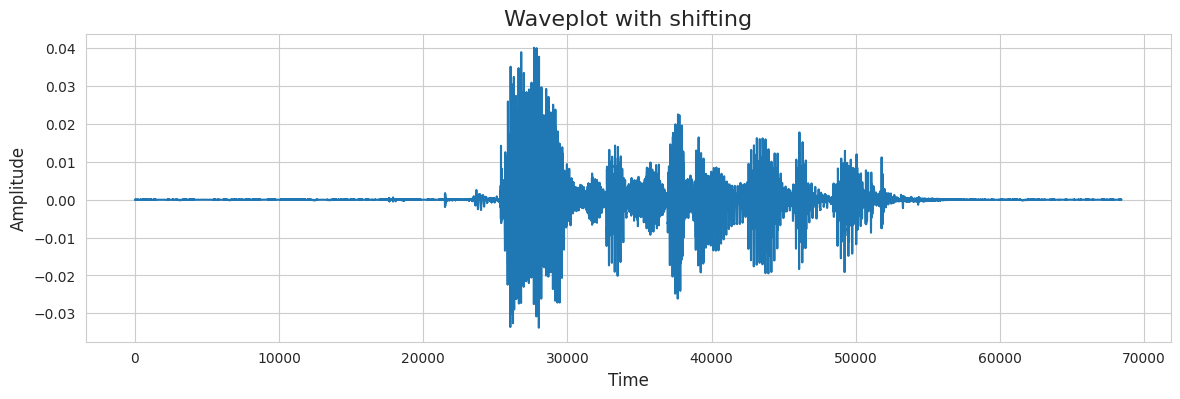

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
plt.plot(x)
plt.title('Waveplot with shifting', size=16)
plt.xlabel('Time', size=12)
plt.ylabel('Amplitude', size=12)
plt.show()
Audio(x, rate=sample_rate)


#### 5. Pitch

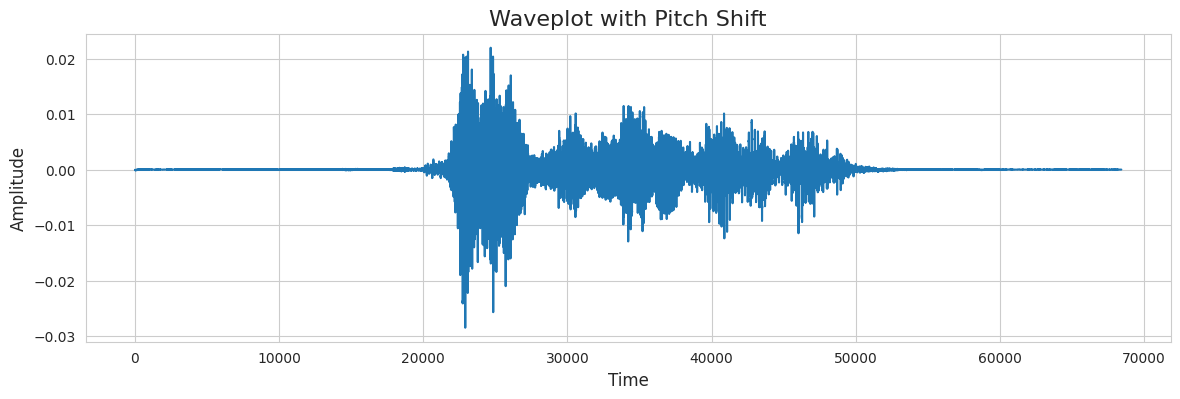

In [ ]:
x = pitch(data, n_steps=1)

plt.figure(figsize=(14, 4))
plt.plot(x)
plt.title('Waveplot with Pitch Shift', size=16)
plt.xlabel('Time', size=12)
plt.ylabel('Amplitude', size=12)
plt.show()

Audio(x, rate=sample_rate)

- From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching.

In [ ]:
def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))  # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))  # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))  # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))  # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))  # stacking horizontally

    # Spectral Contrast
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_contrast))

    # Tonnetz
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(data), sr=sample_rate).T, axis=0)
    result = np.hstack((result, tonnetz))

    # Rolloff
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, rolloff))

    # Zero Crossing Rate Variance
    zcr_var = np.var(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr_var))

    return result

def get_features(pathbaru, sample_rate):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, _ = librosa.load(pathbaru, sr=sample_rate, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2))  # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3))  # stacking vertically

    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    path = path.replace("Actor_", "/Actor_")
    feature = get_features(path, sample_rate)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=862
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=862
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=851
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=817
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=1021
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=828
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257:

In [ ]:
len(X), len(Y), data_path.Path.shape

(4320, 4320, (1440,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features

0         1         2         3         4         5         6  \
0     0.155631  0.652999  0.614690  0.653589  0.641073  0.562788  0.488316   
1     0.299963  0.705151  0.699234  0.730912  0.744556  0.667563  0.552728   
2     0.147700  0.622365  0.605414  0.651221  0.618879  0.535481  0.464065   
3     0.129517  0.552897  0.561556  0.598754  0.608615  0.639215  0.608321   
4     0.331868  0.716747  0.745681  0.771365  0.807248  0.764826  0.635091   
...        ...       ...       ...       ...       ...       ...       ...   
4315  0.332696  0.731829  0.672463  0.677682  0.720882  0.677253  0.603072   
4316  0.187912  0.611041  0.501818  0.517189  0.586156  0.474039  0.458376   
4317  0.178729  0.602784  0.521250  0.484901  0.486272  0.514804  0.656678   
4318  0.248513  0.624247  0.574511  0.543784  0.530593  0.587743  0.706827   
4319  0.170945  0.558799  0.488883  0.481550  0.482434  0.648912  0.665550   

             7         8         9  ...        168       169       170  \
0     0.550705  0.546261  0.492733  ...  45.618273 -0.034534  0.018786   
1     0.591502  0.560551  0.546195  ...  14.164141 -0.003355 -0.006250   
2     0.539917  0.523364  0.465803  ...  46.223387 -0.010736  0.025409   
3     0.656219  0.664895  0.627405  ...  45.297983 -0.038337  0.010017   
4     0.662158  0.685808  0.672286  ...  13.420437 -0.005414 -0.003509   
...        ...       ...       ...  ...        ...       ...       ...   
4315  0.617247  0.652705  0.700105  ...  13.578961 -0.016626 -0.021503   
4316  0.534412  0.566633  0.614457  ...  46.540620 -0.051308 -0.016581   
4317  0.633165  0.635474  0.549707  ...  46.791761 -0.048813  0.124975   
4318  0.651924  0.656931  0.582976  ...  15.272546 -0.009130  0.094207   
4319  0.660205  0.619544  0.446443  ...  47.784786 -0.060024  0.128942   

           171       172       173       174          175       176  \
0     0.086457  0.023465  0.015388  0.012602  5542.307536  0.021377   
1     0.063807  0.037048 -0.002100  0.015503  8029.093424  0.037510   
2     0.081946  0.009965 -0.006122  0.020842  5716.188151  0.021325   
3     0.041248  0.003552  0.007571  0.008536  4594.447835  0.004449   
4     0.039166 -0.000302 -0.006311 -0.002941  8316.302490  0.020785   
...        ...       ...       ...       ...          ...       ...   
4315  0.057231  0.078212 -0.019793  0.002658  8622.353109  0.022849   
4316  0.092535  0.120581 -0.019016  0.008634  5000.089518  0.021837   
4317 -0.028354  0.037264 -0.012282 -0.034410  5353.792318  0.019619   
4318 -0.008406  0.033590  0.005028 -0.028855  6962.302653  0.032448   
4319 -0.015317  0.010869 -0.010583 -0.040146  5423.097331  0.017373   

             labels  
0         depressed  
1         depressed  
2         depressed  
3         depressed  
4         depressed  
...             ...  
4315  non depressed  
4316  non depressed  
4317  non depressed  
4318  non depressed  
4319  non depressed  

[4320 rows x 178 columns]

* We have applied data augmentation and extracted the features for each audio files and saved them.

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 177), (3240, 2), (1080, 177), (1080, 2))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 177), (3240, 2), (1080, 177), (1080, 2))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 177, 1), (3240, 2), (1080, 177, 1), (1080, 2))

## Modelling CNN

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=2, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 177, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 89, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 89, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 45, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 45, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 23, 128)           0

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=70, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/70
51/51 [==============================] - 24s 450ms/step - loss: 0.6736 - accuracy: 0.5506 - val_loss: 0.6545 - val_accuracy: 0.5417 - lr: 0.0010
Epoch 2/70
51/51 [==============================] - 21s 422ms/step - loss: 0.6643 - accuracy: 0.5728 - val_loss: 0.6470 - val_accuracy: 0.5731 - lr: 0.0010
Epoch 3/70
51/51 [==============================] - 23s 448ms/step - loss: 0.6588 - accuracy: 0.5830 - val_loss: 0.6603 - val_accuracy: 0.5806 - lr: 0.0010
Epoch 4/70
51/51 [==============================] - 20s 401ms/step - loss: 0.6508 - accuracy: 0.6009 - val_loss: 0.6536 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 5/70
51/51 [==============================] - 21s 413ms/step - loss: 0.6426 - accuracy: 0.6086 - val_loss: 0.6302 - val_accuracy: 0.5861 - lr: 0.0010
Epoch 6/70
51/51 [==============================] - 20s 393ms/step - loss: 0.6320 - accuracy: 0.6235 - val_loss: 0.6132 - val_accuracy: 0.6130 - lr: 0.0010
Epoch 7/70
51/51 [==============================] - 21s 415ms/st

In [ ]:
# Menampilkan akurasi model pada data uji
accuracy = model.evaluate(x_test, y_test)[1] * 100
print("Akurasi model pada data uji: {:.2f}%".format(accuracy))

# Membuat grafik untuk pelatihan dan pengujian model
epochs = [i for i in range(70)]

# Menyiapkan subplot dan ukuran gambar
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 6)

# Mengambil data pelatihan
train_acc = history.history['accuracy']
train_loss = history.history['loss']

# Mengambil data pengujian
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

# Grafik untuk kehilangan (loss)
ax[0].plot(epochs, train_loss, label='Training loss')
ax[0].plot(epochs, test_loss, label='Testing loss')
ax[0].set_title('Training & testing loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

# Grafik untuk akurasi
ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Testing Accuracy')
ax[1].set_title('Training & testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

# Menampilkan grafik
plt.show()

34/34 [==============================] - 3s 74ms/step - loss: 0.6199 - accuracy: 0.8556
Akurasi model pada data uji: 85.56%


In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

34/34 [==============================] - 2s 44ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head

<bound method NDFrame.head of      Predicted Labels  Actual Labels
0           depressed      depressed
1           depressed      depressed
2           depressed  non depressed
3       non depressed  non depressed
4       non depressed  non depressed
...               ...            ...
1075        depressed      depressed
1076    non depressed      depressed
1077        depressed  non depressed
1078        depressed      depressed
1079    non depressed  non depressed

[1080 rows x 2 columns]>

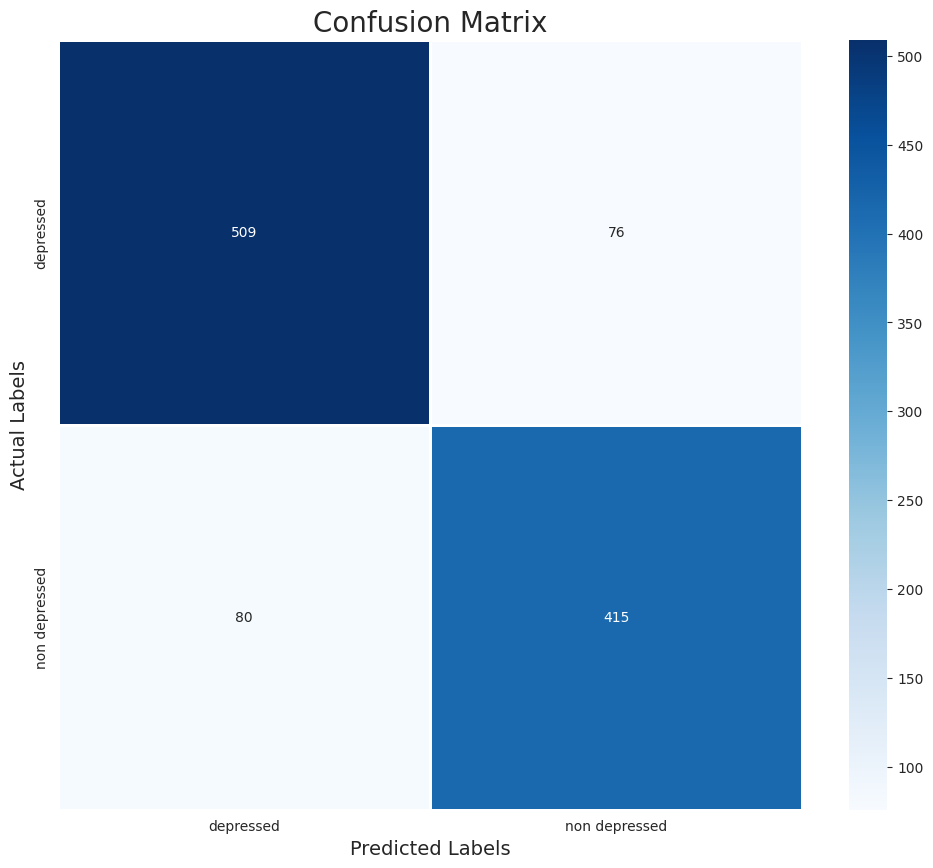

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

    depressed       0.86      0.87      0.87       585
non depressed       0.85      0.84      0.84       495

     accuracy                           0.86      1080
    macro avg       0.85      0.85      0.85      1080
 weighted avg       0.86      0.86      0.86      1080



- We can see our model is more accurate in predicting surprise, angry emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed etc..
- We overall achieved 61% accuracy on our test data and its decent but we can improve it more by applying more augmentation techniques and using other feature extraction methods.